# Imports

In [1]:
import string
import pandas as pd
import numpy as np

from preprocessing import Preprocessor
from data_loader import DataLoader
from helpers import select_n_components
from textblob import TextBlob
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer, FunctionTransformer
from sklearn.base import BaseEstimator

[nltk_data] Downloading package stopwords to
[nltk_data]     /afs/inf.ed.ac.uk/user/s21/s2125219/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Data

In [2]:
df = DataLoader().create_dataframe(remove_duplicates=True, preprocess=True)
df.head()

100%|██████████| 239073/239073 [00:39<00:00, 6077.16it/s]


,phrase_id,phrase,phrase_clean,sentiment_val,label_id,label
22288,222703,"Build some robots , haul 'em to the theatre wi...",build robot haul em theatr late show put myste...,0.083333,1.0,Very negative
223370,98617,"town regret , love , duty and friendship",town regret love duti friendship,0.500000,3.0,Neutral
53708,110101,The problem is the needlessly poor quality of ...,the problem needlessli poor qualiti archiv pri...,0.222220,2.0,Negative
13444,103397,A Better Tomorrow,A better tomorrow,0.555560,3.0,Neutral
108176,197881,energy and passion,energi passion,0.569440,3.0,Neutral


# Train, dev and test split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df['phrase_clean'], 
                                                    df['label_id'], 
                                                    test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.25, 
                                                  random_state=42)

# Feature Engineering

In [4]:
adj = ['JJ', 'JJR', 'JJS']

def pos_check(x):
    count = 0
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in adj:
                count += 1
    except:
        pass
    return count

punct_count = lambda l1, l2: sum([1 for x in l1 if x in l2])
caps_count = lambda l1: sum([1 for x in l1 if x.isupper()])

# Phrase length 
def get_phrase_length(x):
    return np.array([len(t) for t in x]).reshape(-1, 1)

# Punctuation counnt
def get_num_punct(X):
    return np.array([punct_count(x, set(string.punctuation)) for x in X]).reshape(-1, 1)

# Number of capital letters
def get_num_caps(X):
    return np.array([caps_count(x) for x in X]).reshape(-1, 1)

# Number of ADJ POS tags 
def get_adj_count(X):
    return np.array([pos_check(x) for x in X]).reshape(-1, 1)

# Prediction using train, test and dev split

In [6]:
def create_pipeline(classifier):
    clf = Pipeline([
        ('features', FeatureUnion([
            ('text', Pipeline([
                ('vectorizer', TfidfVectorizer(analyzer='word', max_features=10000, use_idf=True, ngram_range=(1,4)))
            ])),
            ('punct', Pipeline([
                ('count', FunctionTransformer(get_num_punct, validate=False))
            ])),
            ('caps', Pipeline([
                ('count', FunctionTransformer(get_num_caps, validate=False))
            ])),
#             ('adj', Pipeline([
#                 ('count', FunctionTransformer(get_adj_count, validate=False))
#             ]))
        ])),
        ('clf', classifier)
    ])
    return clf

classifiers = {
    'Dummy, most frequent': create_pipeline(classifier=DummyClassifier(strategy='most_frequent')),
    'Nearest Neighb (10)': create_pipeline(classifier=KNeighborsClassifier(n_neighbors=10)),
    'Nearest Neighb (5)': create_pipeline(classifier=KNeighborsClassifier(n_neighbors=5)),
    'Logistic Ression': create_pipeline(classifier=LogisticRegression(max_iter=5000)),
    'Linear SVM': create_pipeline(classifier=SVC(kernel='linear')),
    'RBF SVM': create_pipeline(classifier=SVC(kernel='rbf')),
    'Random Forest': create_pipeline(classifier=RandomForestClassifier(max_depth=10, n_estimators=50)),
    'MLP': create_pipeline(classifier=MLPClassifier(max_iter=800)),
    'MLP stronger reg': create_pipeline(classifier=MLPClassifier(max_iter=800, alpha=1))
}

In [ ]:
ca_train_score = {}
ca_val_score = {}

for name, clf in tqdm(classifiers.items()):
    clf.fit(X_train, y_train)
    
    train_preds = clf.predict(X_train)
    val_preds = clf.predict(X_val)
    
    ca_train_score[name] = f1_score(train_preds, y_train, average='weighted')
    ca_val_score[name] = f1_score(val_preds, y_val, average='weighted')

 44%|████▍     | 4/9 [05:48<07:09, 85.99s/it] 

In [ ]:
print('Classification performance on validation set: \n')

print('Validation (LHS), Training (RHS)')
print()
for name, clf in classifiers.items():
    print ("{method:<20s}{val_f1:>13.3f}{train_f1:>13.3f}".format(
        method=name, val_f1=ca_val_score[name],
        train_f1=ca_train_score[name]))

# Unsupervised Clustering
- Ignore this for now.

- KMeans does not work well on high-dimensional data, better to reduce dimensionality of data first, and then do KMeans on reduced space: https://stats.stackexchange.com/questions/199501/user-segmentation-by-clustering-with-sparse-data

In [46]:
from sklearn import metrics

In [62]:
phrases, labels = phrase_df['phrase_clean'], phrase_df['label_id']

In [63]:
k_labels = phrase_df['label_id'].values.tolist()
true_k = np.unique(k_labels).shape[0]

In [109]:
vectorizer = TfidfVectorizer(analyzer='word', 
                             max_features=100,
                             use_idf=True, 
                             ngram_range=(1,1))

X = vectorizer.fit_transform(phrase_df['phrase_clean'])

In [110]:
# svd = TruncatedSVD(n_components=500)
# normalizer = Normalizer(copy=False)
# lsa = make_pipeline(svd, normalizer)
# X = lsa.fit_transform(X_vect)

# print(svd.explained_variance_ratio_.sum())

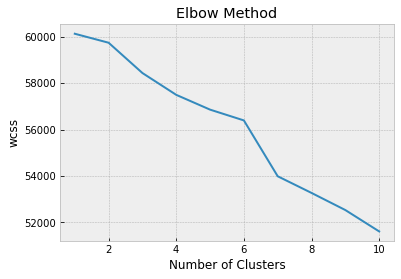

In [111]:
# Elbow method for finding optimal number of clusters
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=1, max_iter=100, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()

In [114]:
km = KMeans(n_clusters=6, init='k-means++', max_iter=100, n_init=1)
km.fit(X)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Homogeneity: 0.006
Completeness: 0.016
V-measure: 0.009
Adjusted Rand-Index: 0.354
Silhouette Coefficient: 0.326


/afs/inf.ed.ac.uk/user/s21/s2125219/miniconda3/envs/dme/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
/afs/inf.ed.ac.uk/user/s21/s2125219/miniconda3/envs/dme/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))


In [115]:
# original_space_centroids = svd.inverse_transform(km.cluster_centers_)
# order_centroids = original_space_centroids.argsort()[:, ::-1]

order_centroids = km.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names()

for i in range(6):
    print("Cluster %d: " % i, end='')
    for idx in order_centroids[i, :200]:
        print(' %s' % terms[idx], end='')
    print('\n')

Cluster 0:  movi one charact stori make comedi perform even good work much director life littl well way funni get enough look us new plot come action audienc act entertain bad emot interest thing year two take feel end see self watch old best drama go never humor someth world would peopl live seem cast heart mani scene direct minut made everi give filmmak sens pictur star actor screen big long man could american may without play fun better hollywood still show origin anoth famili less great realli power first real noth enjoy ever tri kind find film like time love human

Cluster 1:  time movi good first film one long minut like mani much take well feel stori get director watch work make way everi seem screen come look big interest even real two great us give go charact could act old realli better plot littl direct live enjoy anoth funni emot life see end peopl still kind drama year someth sens audienc power action show less bad would cast tri actor filmmak play entertain find new thing 